# MODELOS PREDICTIVOS COVID MURCIA

In [1]:
from pandas import read_csv
import pandas as pd
from pandas.plotting import lag_plot
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
import io

Lectura del conjunto de datos obtenido de la pagina de salud de Murcia 
https://www.murciasalud.es/pagina.php?id=458869
Recogidos desde el 08/03/2020 hasta el dia 25/03/2020

In [ ]:
lectura = read_csv('../Datos_originales/casos_diarios_total_regional.csv', skiprows = 4, encoding='latin-1', sep = ';', na_values = ['NaN', 'NaT'])

# Headers = columnas de mi conjunto de datos. Si no especificamos asume que son las de la primera fila leida
# Skiprows = n: con n = numero de filas que quiero saltar. Las cuatro primeras son texto -> las saltamos
# Encoding = 'latin-1': para que no de errores de codificacion de algunos caracteres 
# Sep = ';': delimitador que separa las columnas
# Index_col = 0: usar la primera columna (fechas) como filas del dataframe

Renombramos los nombres de algunas de las columnas para que queden mas compactos

In [ ]:
datos = lectura.rename(columns={'Pruebas_PCR_Ag':'Pruebas',
                                'Casos_incidentes_PCR/Ag+':'Incidentes',
                                'Hospitalizados': 'H',
                                'Hospitaliz_UCI':'H_UCI',
                                'Asintomatico_hombre_<45años': 'Asint_H_<45',
                                'Asintomatico_hombre_45a64años': 'Asint_H_45a64',
                                'Asintomatico_hombre_+65años': 'Asint_H_+65',
                                'Sintomatico_hombre_<45años': 'Sint_H_<45',
                                'Sintomatico_hombre_45a64años': 'Sint_H_45a64',
                                'Sintomatico_hombre_+65años': 'Sint_H_+65',
                                'Asintomatico_mujer_<45años': 'Asint_M_<45',
                                'Asintomatico_mujer_45a64años': 'Asint_M_45a64',
                                'Asintomatico_mujer_+65años': 'Asint_M_+65',
                                'Sintomatico_mujer_<45años': 'Sint_M_<45',
                                'Sintomatico_mujer_45a64años': 'Sint_M_45a64',
                                'Sintomatico_mujer_+65años': 'Sint_M_+65'})

Convertimos los datos leidos en un dataFrame y lo mostramos para ver su apariencia

In [ ]:
df_salud_murcia = pd.DataFrame(datos)
df_salud_murcia.head(3)

Lo siguiente que haremos es indexar el dataframe por la columna 'Fecha'. Para ello, primero debemos convertir la misma en un objeto de tipo DatatimeIndex. Usamos la funcion 'to_datetime' y le indicamos el formato en el que se encuentran las fechas para que se lea y procese bien. Posteriormente eliminamos la columna del dataFrame e insertamos el nuevo DatatimeIndex como íncide del dataframe. Finalmente mostramos el resultado.

In [ ]:
format = '%d/%m/%Y'
datetime_fecha = pd.to_datetime(df_salud_murcia['Fecha'], format = format)
df_salud_murcia = df_salud_murcia.drop(['Fecha'], axis=1)
df_salud_murcia.insert(0,'Fecha', datetime_fecha)
df_salud_murcia = df_salud_murcia.set_index('Fecha')
df_salud_murcia.head(3)

Con la siguiente función eliminamos todos aquellos valores que se almacenan o completan como NaN. 

In [ ]:
df_salud_murcia.dropna(axis = 0, inplace = True)

## Sumando sintomáticos y asintomáticos
En esta sección vamos a sumar a todos los asintomáticos (por fecha) y añadirlos en una nueva serie
del dataframe a la que llamaré "Asintomaticos"

In [ ]:
df_salud_murcia['Asintomaticos'] = df_salud_murcia['Asint_H_<45'] + df_salud_murcia['Asint_H_45a64'] + df_salud_murcia['Asint_H_+65'] + df_salud_murcia['Asint_M_<45'] + df_salud_murcia['Asint_M_45a64'] + df_salud_murcia['Asint_M_+65']
df_salud_murcia['Sintomaticos'] = df_salud_murcia['Sint_H_<45'] + df_salud_murcia['Sint_H_45a64'] + df_salud_murcia['Sint_H_+65'] + df_salud_murcia['Sint_M_<45'] + df_salud_murcia['Sint_M_45a64'] + df_salud_murcia['Sint_M_+65']

A continuación lo que hacemos es guardarla en un archivo de extensión .csv 

In [ ]:
df_salud_murcia.to_csv(path_or_buf = '../Datos_preprocesados./datos_murcia_asint_sint.csv')

Al igual que hicimos con el dataFrame de los datos de salud que leímos al principio, debemos transformar las fechas en objetos de tipo DatatimeIndex. Posteriormente las ordenaremos para que se muestren en orden cronológico. Para ello usamos la función 'to_datetime', que convierte nuestra lista de fechas en DatatimeIndex. Acto seguido creamos el dataframe con las entradas, las salidas a Murcia y las fechas y las ponemos como índice del dataframe. Ahora solo queda ordenarlo. Añadimos tres columnas adicionales al dataframe que son los meses, dias y años de las fechas. Ordenamos según estos valores y posteriormente las eliminamos del dataframe. Mostramos el resultado.

In [ ]:
def conversor_a_dataframe(lista_fechas, lista_entradas, lista_salidas):
    format = '%Y-%d-%m'
    # Convertimos en DatatimeIndex
    fechas_serie = pd.to_datetime(lista_fechas, format = format)
    # Creamos dataframe con las entradas salidas y fechas
    df_entradas_salidas = pd.DataFrame(list(zip(lista_entradas, lista_salidas)), columns = ['Entradas', 'Salidas'], index = fechas_serie).rename_axis('Fecha', axis = 0)
    # Definimos las series para ordenar
    df_entradas_salidas['month'] = fechas_serie.month
    df_entradas_salidas['year'] = fechas_serie.year
    df_entradas_salidas['day'] = fechas_serie.day
    # Ordenamos por mes-dia-año
    df_entradas_salidas = df_entradas_salidas.sort_values(['year', 'month', 'day']).drop(columns=['day', 'month', 'year'])
    return df_entradas_salidas

## Añadiendo Movilidad

El código del municipio de Murcia es 30030. Usaremos este código para acceder a los datos de movilidad de la ciudad
del ministerio recogidos en la carpeta mitma_movilidad. Para cada mes tenemos un archivo .tar con ficheros .txt
correspondientes a cada dia

In [ ]:
def parseador_fechas_mitma(nombre):
    # Cogemos el día
    dia = nombre[6:8]
    mes = nombre[4:6]
    anio = nombre[0:4]
    return(anio+'-'+dia+'-'+mes)

In [ ]:
ruta = '../Datos_originales/mitma_movilidad/'

lista_fechas = []
lista_entradas = []
lista_salidas = []


# Cogemos los archivos .tar mensuales
archivos = os.listdir(ruta)

for a in archivos:
    meses = os.listdir(ruta+a)
    for m in meses:
        if "._" not in m:
            # Obtenemos la fecha
            fecha = parseador_fechas_mitma(m)
            lista_fechas.append(fecha)
            # Leemos el archivo correspondiente
            df = pd.read_csv(ruta+a+'/'+m, compression='gzip', sep='|', header=0, low_memory = False)
            # Nos quedamos solo con Murcia código 30030
            df_s = df[df['origen'].str.contains('30030', na=False)]
            # Eliminamos los viajes de Murcia a Murcia
            df_s = df_s[df_s['destino'].str.contains('30030', na=False) == False]
            # Nos quedamos solo con Murcia código 30030
            df_e = df[df['destino'].str.contains('30030', na=False)]
            # Eliminamos los viajes de Murcia a Murcia
            df_e = df_e[df_e['origen'].str.contains('30030', na=False) == False]
            # Sumamos todos los viajes que son las entradas y salidas
            salidas = df_s['viajes'].sum()
            entradas = df_e['viajes'].sum()
            # Añadimos a las listas
            lista_salidas.append(salidas)
            lista_entradas.append(entradas)

In [ ]:
df_mitma = conversor_a_dataframe(lista_fechas, lista_entradas, lista_salidas)
df_mitma.tail(3)

Vemos ahora el número de filas y el número de missing values

In [ ]:
df_mitma.shape

In [ ]:
df_mitma.isna().sum()

In [ ]:
df_final_mitma = pd.concat([df_salud_murcia, df_mitma], axis=1)

In [ ]:
df_final_mitma.to_csv(path_or_buf = '../Datos_preprocesados/datos_murcia_mas_entradas_salidas_mitma.csv')

In [2]:
df_final_mitma = read_csv('../Datos_preprocesados/datos_murcia_mas_entradas_salidas_mitma.csv', encoding='latin-1', sep = ',', na_values = ['NaN', 'NaT'])
df_final_mitma = df_final_mitma.set_index('Fecha')

In [3]:
df_final_mitma.head(5)

,Pruebas,Incidentes,H,H_UCI,Defunciones,Asint_H_<45,Asint_H_45a64,Asint_H_+65,Sint_H_<45,Sint_H_45a64,...,Asint_M_<45,Asint_M_45a64,Asint_M_+65,Sint_M_<45,Sint_M_45a64,Sint_M_+65,Asintomaticos,Sintomaticos,Entradas,Salidas
Fecha,,,,,,,,,,,,,,,,,,,,,
2020-02-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,325378.804,336409.734
2020-02-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,264680.806,271125.590
2020-02-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,241551.229,229344.298
2020-02-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,317429.211,314793.779
2020-02-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,323989.452,323119.150


Contamos de nuevo las filas y el número de missing values

In [ ]:
df_final_mitma.shape

In [ ]:
df_final_mitma.isna().sum()

## Visualicación series (bucle)

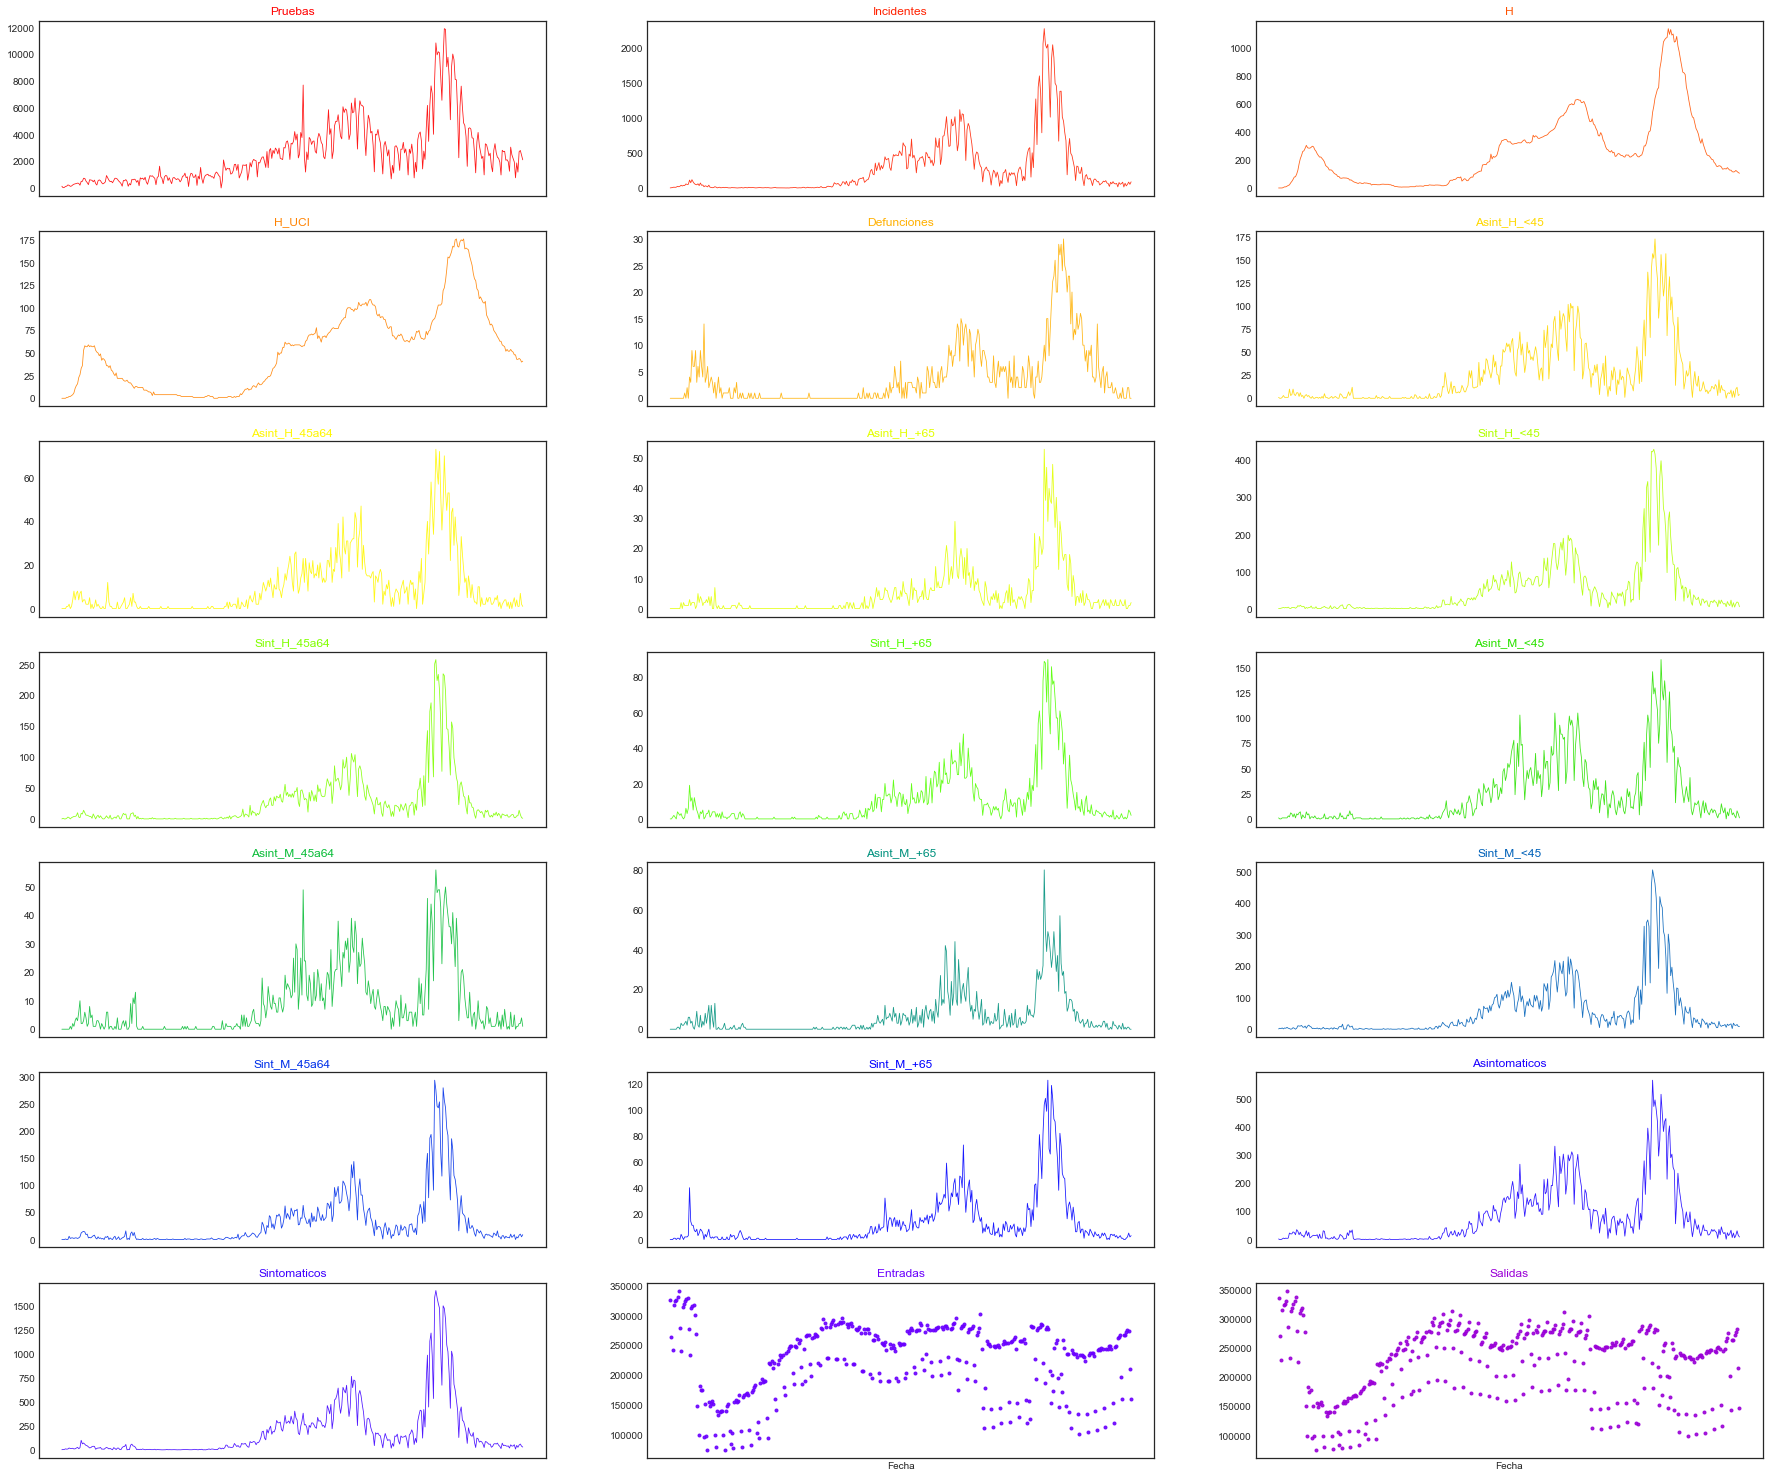

In [4]:
num = 0

# Initialize the figure style
plt.style.use('seaborn-white')
 
# create a color palette

palette = plt.get_cmap('prism')

for column in df_final_mitma:
    
    num = num + 1
 
    # Find the right spot on the plot
    plt.subplot(7,3, num)
 
    if "Salidas" in column or "Entradas" in column:
        serie = df_final_mitma[column]
        serie.plot(style = '.', color = palette(num), linewidth = 0.8, alpha = 0.9, label = column)
    else:
        # Plot the lineplot
        plt.plot(df_final_mitma[column], marker = '', color = palette(num), linewidth = 0.8, alpha = 0.9, label = column)

    # Add title
    plt.title(column, loc ='center', fontsize = 12, fontweight = 0, color = palette(num))

    plt.xticks([])
    #plt.xticks(rotation=90)
    
plt.subplots_adjust(left = 0.01, right = 4, top = 5, bottom = 0.01, hspace = 0.2, wspace = 0.2)


# Show the graph
plt.show()

## Predictor

In [ ]:
df_salud_murcia.isna().sum()

In [ ]:
df_final_mitma.head(5)

In [ ]:
df_final_mitma = df_final_mitma.drop(['Asint_H_<45', 'Asint_H_45a64', 'Asint_H_+65', 'Asint_M_<45', 'Asint_M_45a64', 'Asint_M_+65', 'Sint_H_<45', 'Sint_H_45a64', 'Sint_H_+65', 'Sint_M_<45', 'Sint_M_45a64', 'Sint_M_+65'], axis=1)

In [ ]:
df_final_mitma.head(5)

In [ ]:
df_final_mitma.to_csv(path_or_buf = '../Datos_preprocesados/datos_mitma_final.csv')

In [ ]:
df_final_mitma = read_csv('../Datos_preprocesados/datos_mitma_final.csv', encoding='latin-1', sep = ',', na_values = ['NaN', 'NaT'])
df_final_mitma = df_final_mitma.set_index('Fecha')
df_final_mitma.head(5)

In [ ]:
df_predictor = df_final_mitma.copy()
columnas = df_predictor.columns
#columnas = columnas.drop("Incidentes")
lista = []
# Añadimos lag a todas las series excepto a Incidentes, que es la que queremos predecir
for c in columnas:
    datos = pd.DataFrame(df_predictor[c].values, index = df_predictor.index)
    for i in [3,2,1]:
        df_predictor.insert(len(df_predictor.columns), c+' t-'+str(i),datos.shift(i))
        lista.append(df_predictor.columns)

columnas = columnas.drop("Incidentes")
df_predictor = df_predictor.drop(columnas, axis=1)

In [ ]:
df_predictor.head(4)

In [ ]:
df_predictor.shape

In [ ]:
df_predictor.isna().sum()

In [ ]:
df_predictor.dropna(axis = 0, inplace = True)
df_predictor.head(3)

In [ ]:
df_predictor.shape

In [ ]:
df_predictor.to_csv(path_or_buf = '../Datos_preprocesados/predictor.csv')

In [5]:
df_predictor = read_csv('../Datos_preprocesados/predictor.csv', encoding='latin-1', sep = ',', na_values = ['NaN', 'NaT'])
df_predictor = df_predictor.set_index('Fecha')
df_predictor.head(5)

,Incidentes,Pruebas t-3,Pruebas t-2,Pruebas t-1,Incidentes t-3,Incidentes t-2,Incidentes t-1,H t-3,H t-2,H t-1,...,Asintomaticos t-1,Sintomaticos t-3,Sintomaticos t-2,Sintomaticos t-1,Entradas t-3,Entradas t-2,Entradas t-1,Salidas t-3,Salidas t-2,Salidas t-1
Fecha,,,,,,,,,,,,,,,,,,,,,
2020-03-11,12.0,130.0,21.0,39.0,1.0,3.0,6.0,0.0,0.0,0.0,...,0.0,1.0,4.0,4.0,233114.055,312749.656,315375.300,226284.440,309733.557,315520.132
2020-03-12,9.0,21.0,39.0,116.0,3.0,6.0,12.0,0.0,0.0,0.0,...,2.0,4.0,4.0,10.0,312749.656,315375.300,317101.141,309733.557,315520.132,318225.510
2020-03-13,12.0,39.0,116.0,136.0,6.0,12.0,9.0,0.0,0.0,4.0,...,5.0,4.0,10.0,7.0,315375.300,317101.141,300505.264,315520.132,318225.510,306428.780
2020-03-14,23.0,116.0,136.0,228.0,12.0,9.0,12.0,0.0,4.0,8.0,...,3.0,10.0,7.0,9.0,317101.141,300505.264,269382.076,318225.510,306428.780,278294.481
2020-03-15,18.0,136.0,228.0,196.0,9.0,12.0,23.0,4.0,8.0,8.0,...,5.0,7.0,9.0,19.0,300505.264,269382.076,147957.126,306428.780,278294.481,151130.656


## Predictor sin movilidad

In [ ]:
sin_mov = read_csv('../Datos_preprocesados/datos_murcia_asint_sint.csv', encoding='latin-1', sep = ',', na_values = ['NaN', 'NaT'])
sin_mov = sin_mov.set_index('Fecha')
sin_mov.head(3)

In [ ]:
sin_mov = sin_mov.drop(['Asint_H_<45', 'Asint_H_45a64', 'Asint_H_+65', 'Asint_M_<45', 'Asint_M_45a64', 'Asint_M_+65', 'Sint_H_<45', 'Sint_H_45a64', 'Sint_H_+65', 'Sint_M_<45', 'Sint_M_45a64', 'Sint_M_+65'], axis=1)

In [ ]:
pred_sin_mov = sin_mov.copy()
columnas = pred_sin_mov.columns
#columnas = columnas.drop("Incidentes")
lista = []
# Añadimos lag a todas las series excepto a Incidentes, que es la que queremos predecir
for c in columnas:
    datos = pd.DataFrame(pred_sin_mov[c].values, index = pred_sin_mov.index)
    for i in [3,2,1]:
        pred_sin_mov.insert(len(pred_sin_mov.columns), c+' t-'+str(i),datos.shift(i))
        lista.append(pred_sin_mov.columns)

columnas = columnas.drop("Incidentes")
pred_sin_mov = pred_sin_mov.drop(columnas, axis=1)

In [ ]:
pred_sin_mov.dropna(axis = 0, inplace = True)
pred_sin_mov.head(3)

In [ ]:
pred_sin_mov.shape

In [ ]:
pred_sin_mov.to_csv(path_or_buf = '../Datos_preprocesados/predictor_sin_mov.csv')

In [ ]:
pred_sin_mov = read_csv('../Datos_preprocesados/predictor_sin_mov.csv', encoding='latin-1', sep = ',', na_values = ['NaN', 'NaT'])
pred_sin_mov = pred_sin_mov.set_index('Fecha')
pred_sin_mov.head(5)

## Normalización de datos

En este apartado realizamos una normalización de los atributos de nuestros datos. Para ello usamos el normalizador que 
ofrece Python llamado Max-Min Scaler

Nos quedamos con el índice del dataframe para luego poder añadirselo al nuevo dataframe escalado

In [ ]:
index = df_predictor.index

Normalización con max-min scaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
escalado = scaler.fit_transform(df_predictor)
df_escalado = pd.DataFrame(escalado, columns = df_predictor.columns).set_index(index)
df_escalado.head(3)

# Predicción indicentes (sin escalar)

In [6]:
# Imports
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
import sklearn.metrics as sm
from sklearn.linear_model import Lasso
from sklearn import svm
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import math
# Para guardar los modelos entrenados
import joblib as joblib

Dividimos el conjunto de datos con una distribución 80% para train y 20% para test sin perder la temporalidad

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df_predictor.drop(['Incidentes'], axis=1),
                                        df_predictor['Incidentes'], train_size = 0.8, test_size = 0.2, 
                                        random_state = 42, shuffle = False)

Usamos el cross validator de time series con 10 pliegues

In [8]:
cv = TimeSeriesSplit(n_splits = 10)

In [ ]:
from sklearn.metrics import make_scorer
miscorer = make_scorer(sm.mean_absolute_error,greater_is_better=False)

Función de búsqueda de hiperparámetros con gridSearchCV

In [9]:
def search_grid(estimador, grid):
    # Buscamos los mejores hiperparametros
    clf = GridSearchCV(estimator=estimador, 
                        param_grid=grid,
                        cv=cv,
                        #refit=True,
                        #error_score=0,
                        # POR DEFECTO -> R^2
                        #scoring = miscorer,#'neg_root_mean_squared_error',
                        n_jobs=-1,
                        return_train_score=True)

    clf.fit(X_train, y_train)
    
    return clf

Cálculo de errores MAE y RMSE

In [10]:
def MAE(y_pred, y_test):
    print("Mean absolute error =", round(sm.mean_absolute_error(y_test, y_pred), 2))

In [11]:
def RMSE(y_pred, y_test):
    print("RMSE =", round(math.sqrt(sm.mean_squared_error(y_test, y_pred)), 2))

Función para calcular la gráfica de comparación entre incidentes reales y predecidos en el instante t+i

In [19]:
def grafica(y_pred, y_test, i):
    
    #plt.subplot(3,3,1)
    pd.Series(y_pred).plot(color = 'darkorange', linewidth = 1.4, alpha = 0.9, label = 'Incidentes predecidos')
    y_test.plot(color = 'deepskyblue', linewidth = 1.4, alpha = 0.9, label = 'Incidentes Reales') 
    
    plt.title('Indicentes t+'+str(i+1), loc ='center', fontsize = 12, fontweight = 0, color = 'black')
    
    plt.legend(loc='best')

    #plt.subplots_adjust(left = 0.01, right = 4, top = 3, bottom = 0.01, hspace = 0.1, wspace = 0.1)
    plt.xticks(rotation=90)
    plt.show()

Función para el cálculo de las predicciones 7 días adelante a partir de la predicción t para el modelo indicado

In [12]:
def calcular_predicciones(modelo, y_pred):
    predicciones = []
    X_test_modelo = X_test.copy()
    for i in range(7):
        # Modificamos el conjunto de test
        X_test_modelo['Incidentes t-3'] = X_test_modelo['Incidentes t-2']
        X_test_modelo['Incidentes t-2'] = X_test_modelo['Incidentes t-1']
        X_test_modelo['Incidentes t-1'] = y_pred
        # Predecimos
        y_pred = modelo.predict(X_test_modelo)
        # Ajustamos al tamaño
        pred = y_pred[i:]
        predicciones.append(pred)
    return predicciones

Función para calcular los errores y las gráficas asociadas a las predicciones realizadas en la función anterior

In [13]:
def graficas_errores(predicciones):
    erroresMAE = []
    erroresRMSE = []
    bis = y_test.copy()
    for i in range(len(predicciones)):
        test = bis.shift(-i)
        test.dropna(axis = 0, inplace = True)
        # Graficas
        grafica(predicciones[i],test,i)
        # Errores MAE
        erroresMAE.append(MAE(predicciones[i],test))
        # Errores RMSE
        erroresRMSE.append(RMSE(predicciones[i],test))
    return erroresMAE, erroresRMSE

## Random Forest

### Predicción t

In [61]:
rf = RandomForestRegressor(random_state = 42)

Lo siguiente que hacemos es hacer la búsqueda de hiperparámetros, para ello usaremos GridSearchCV, que prueba todas las posibles combinaciones de parámetros que se le pase usando crossvalidación. Veamos cuáles son los hiperparámetros de RF y sus valores por defecto

In [62]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

- n_estimators: número de árboles 
- criterion: medida de calidad de cada división
- max_depth: la máxima profundidad del árbol
- min_samples_split: el mínimo número de muestras requeridas para dividir un nodo interno
- min_samples_lead: mínimo número de muestras requeridas para ser nodo hoja
- min_weight_fraction_lead: la fracción ponderada mínima de la suma total de pesos (de todas las muestras de entrada) necesaria para estar en un nodo hoja
- max_features: número de características miradas al buscar el mejor split ({auto, sqrt, log2})
- max_leaf_nodes: número máximo de nodos hoja
- n_jobs: número de trabajos a correr en paralelo
- max_samples: si hay bootstrapping es el número de muestras a extraer para estimar 
- ...

In [63]:
grid = {
    'bootstrap': [True],
    'max_depth': [20, 50, 60, 70, 80],
    'max_features': [2, 3, 5],
    'min_samples_leaf': [1, 2, 4, 5],
    'min_samples_split': [4, 8, 10, 14],
    'n_estimators': [100, 300, 500, 1000, 1500]
}

In [64]:
clf_rf = search_grid(rf, grid)

In [65]:
optimised_rf = clf_rf.best_estimator_

In [66]:
clf_rf.best_params_

{'bootstrap': True,
 'max_depth': 50,
 'max_features': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'n_estimators': 500}

In [67]:
rf_results = pd.DataFrame(clf_rf.cv_results_)
rf_results.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.261101,0.021395,0.016556,0.004398,True,20,2,1,4,100,...,0.939309,0.940144,0.931976,0.953124,0.985778,0.986393,0.987369,0.981259,0.952513,0.029759
1,0.690253,0.041180,0.035206,0.005867,True,20,2,1,4,300,...,0.934668,0.938379,0.926983,0.956939,0.986634,0.985376,0.986608,0.980033,0.950599,0.031707
2,1.085396,0.057554,0.053557,0.002233,True,20,2,1,4,500,...,0.932997,0.937299,0.927834,0.959023,0.986980,0.985600,0.986423,0.980341,0.950809,0.031742


In [68]:
joblib.dump(optimised_rf, 'rf.pkl')

['rf.pkl']

In [69]:
optimised_rf = joblib.load('rf.pkl')

In [70]:
y_pred = optimised_rf.predict(X_test)

In [72]:
MAE(y_pred, y_test)

Mean absolute error = 324.83


In [73]:
RMSE(y_pred, y_test)

RMSE = 514.84


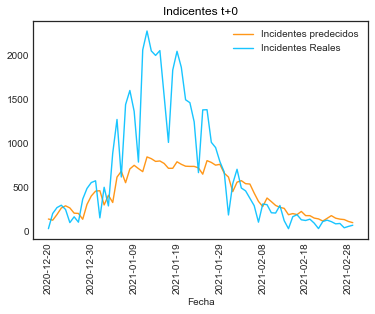

In [75]:
grafica(y_pred, y_test, -1)

In [76]:
np.corrcoef(y_test, y_pred)

array([[1.        , 0.84910118],
       [0.84910118, 1.        ]])

### Predicción 7 días adelante

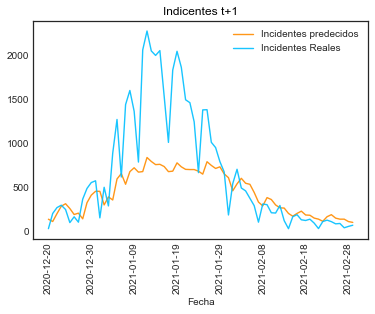

Mean absolute error = 332.74
RMSE = 526.15


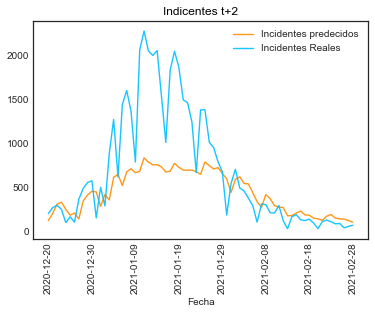

Mean absolute error = 337.87
RMSE = 531.41


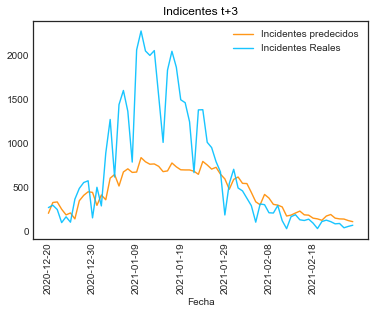

Mean absolute error = 340.6
RMSE = 534.04


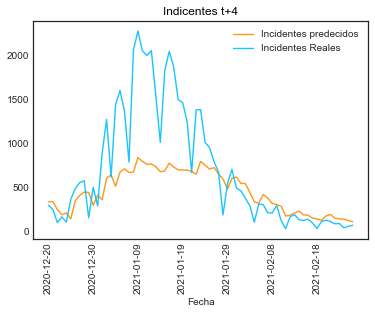

Mean absolute error = 345.13
RMSE = 538.13


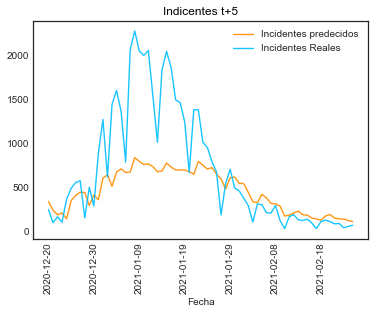

Mean absolute error = 349.83
RMSE = 542.14


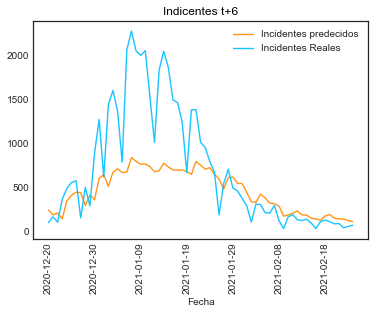

Mean absolute error = 353.8
RMSE = 546.02


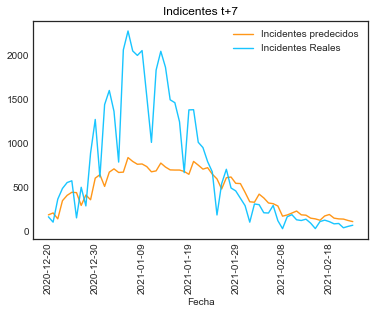

Mean absolute error = 357.08
RMSE = 549.88


In [77]:
predicciones_rf = calcular_predicciones(optimised_rf, y_pred)
MAE_rf, RMSE_rf = graficas_errores(predicciones_rf)

## Linear Regression

### Predicción t

In [ ]:
regresion_lineal = LinearRegression()

In [ ]:
regresion_lineal.fit(X_train, y_train)

In [ ]:
joblib.dump(regresion_lineal, 'regresion_lineal.pkl')

In [14]:
regresion_lineal = joblib.load('regresion_lineal.pkl')

In [15]:
y_pred = regresion_lineal.predict(X_test)

In [16]:
MAE(y_pred, y_test)

Mean absolute error = 195.53


In [17]:
RMSE(y_pred, y_test)

RMSE = 292.89


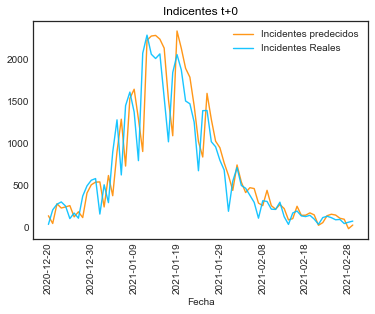

In [20]:
grafica(y_pred, y_test, -1)

In [21]:
np.corrcoef(y_test, y_pred)

array([[1.        , 0.90795707],
       [0.90795707, 1.        ]])

### Predicción 7 días adelante

Creamos una lista donde irán las predicciones t+i con i = 1,...,7

In [22]:
predicciones_LR = calcular_predicciones(regresion_lineal, y_pred)

Calculamos las gráficas de las predicciones así como los errores

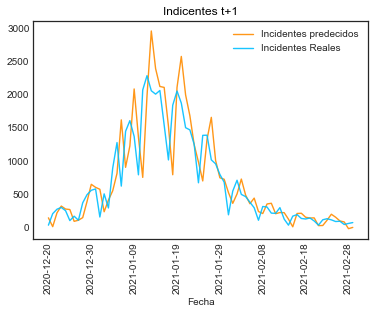

Mean absolute error = 235.17
RMSE = 366.05


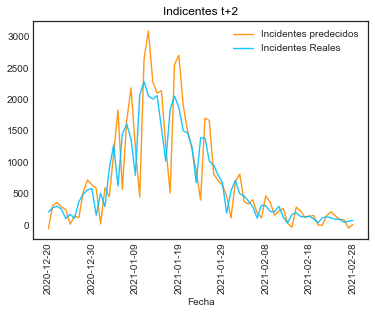

Mean absolute error = 271.46
RMSE = 434.55


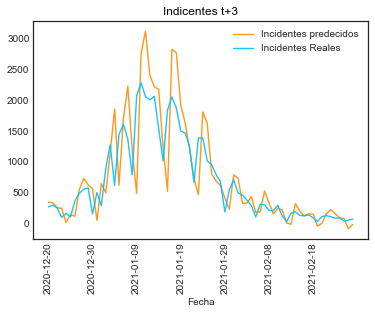

Mean absolute error = 280.83
RMSE = 441.05


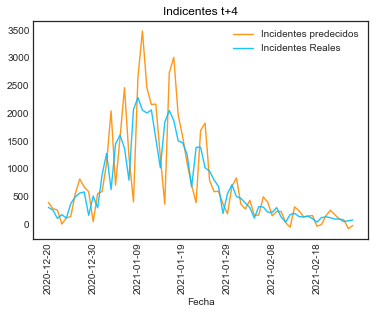

Mean absolute error = 307.02
RMSE = 495.66


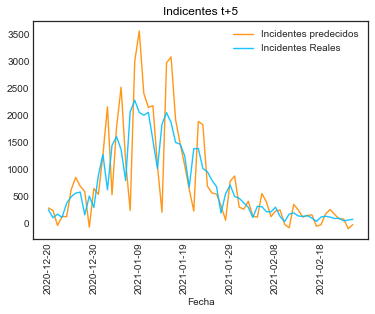

Mean absolute error = 348.59
RMSE = 554.72


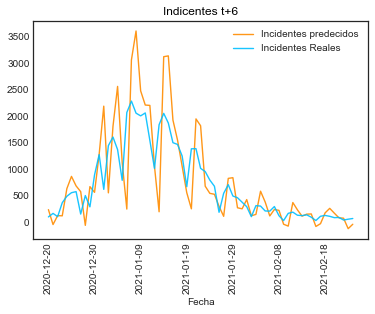

Mean absolute error = 363.15
RMSE = 568.22


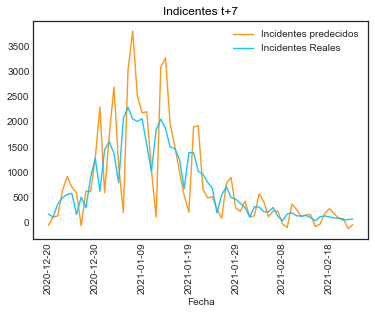

Mean absolute error = 380.06
RMSE = 603.61


In [23]:
MAE_LR, RMSE_LR = graficas_errores(predicciones_LR)

## SVR 

In [ ]:
# División del conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(df_escalado.drop(['Incidentes'], axis=1),
                                        df_escalado['Incidentes'], train_size = 0.8, test_size = 0.2, 
                                        random_state = 42, shuffle = False)

In [ ]:
svr = svm.SVR()

In [ ]:
svr.get_params()

- Kernel
    - Lineal: nuestros datos no siguen un orden lineal, podemos descartarlo
    - Polinomial: OK
    - Radial: kernel gaussiano, OK
    - Sigmoid: OK
- Epsilon
- Degree: es el grado del polinomio
- 0.1 < c < 100

In [ ]:
grid = {#'C' : [0.25, 0.5, 1, 2, 4, 8, 16, 32, 64],
        'C' : [0.001, 0.01, 0.1, 1],
        'epsilon' : [0.1, 0.01, 0.05],
        'gamma' : ['auto'],
        'degree' : [2,3,4],
        'kernel' : ['poly'],
        'coef0' : [0.0, 0.01, 0.05, 0.1]} 

In [ ]:
clf_svr = search_grid(svr, grid)

In [ ]:
optimised_svr = clf_svr.best_estimator_

In [ ]:
clf_svr.best_params_

In [ ]:
svr_results = pd.DataFrame(clf_svr.cv_results_)
svr_results.head(3)

In [ ]:
y_pred = optimised_svr.predict(X_test)

In [ ]:
MAE(y_pred)

In [ ]:
RMSE(y_pred)

In [ ]:
grafica(y_pred)

## Lasso

### Predicción t

In [31]:
lasso = Lasso(random_state = 42)

(1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1

In [32]:
lasso.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'normalize': False,
 'positive': False,
 'precompute': False,
 'random_state': 42,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

- Alpha: es el coeficiente que multiplica al factor de regularización L1 (por defecto es 1)
- Max_iter: número máximo de iteraciones (por defecto está a 1000)
- Tol: tolerancia en la optimización (por defecto es 0.0001)

In [33]:
grid = {'alpha' : [0.9, 1, 1.1, 1.2, 1.3, 1.5],
        'max_iter' : [1000, 3000, 5000, 7000, 10000],
        'tol' : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.5]}

In [34]:
clf_lasso = search_grid(lasso, grid)

In [35]:
clf_lasso.best_params_

{'alpha': 1.1, 'max_iter': 1000, 'tol': 0.1}

In [36]:
lasso_results = pd.DataFrame(clf_lasso.cv_results_)#.sort_values(by = ['rank_test_score'])
#lasso_results.head(3)
#lasso_results[
#    ['params', 'rank_test_score', 'mean_test_score', 'std_test_score']]
lasso_results.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_max_iter,param_tol,params,split0_test_score,split1_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.014960,0.002139,0.004289,0.001003,0.9,1000,0.0001,"{'alpha': 0.9, 'max_iter': 1000, 'tol': 0.0001}",-62.798387,-22.36362,...,0.905642,0.902944,0.852914,0.850468,0.954389,0.944791,0.947197,0.933084,0.913955,0.035779
1,0.015956,0.004719,0.004389,0.001017,0.9,1000,0.001,"{'alpha': 0.9, 'max_iter': 1000, 'tol': 0.001}",-62.798387,-22.36362,...,0.905642,0.902944,0.852914,0.850468,0.954389,0.944791,0.947197,0.933084,0.913955,0.035779
2,0.015658,0.004279,0.003491,0.000500,0.9,1000,0.01,"{'alpha': 0.9, 'max_iter': 1000, 'tol': 0.01}",-62.798387,-22.36362,...,0.905642,0.902944,0.852914,0.850468,0.954389,0.944791,0.947197,0.933084,0.913955,0.035779


In [37]:
optimised_lasso = clf_lasso.best_estimator_

In [38]:
joblib.dump(optimised_lasso, 'lasso.pkl')

['lasso.pkl']

In [39]:
optimised_lasso = joblib.load('lasso.pkl')

In [40]:
y_pred = optimised_lasso.predict(X_test)

In [41]:
MAE(y_pred, y_test)

Mean absolute error = 218.93


In [42]:
RMSE(y_pred, y_test)

RMSE = 305.62


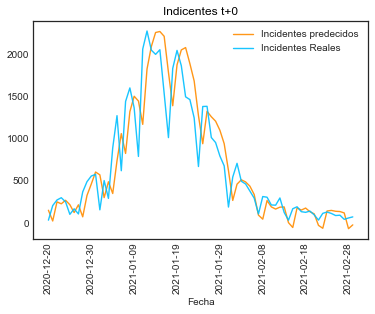

In [43]:
grafica(y_pred, y_test, -1)

In [44]:
np.corrcoef(y_test, y_pred)

array([[1.        , 0.90073577],
       [0.90073577, 1.        ]])

### Predicción 7 días adelante

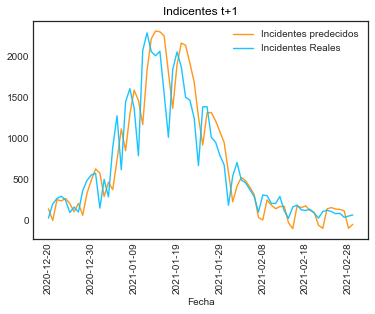

Mean absolute error = 231.27
RMSE = 315.08


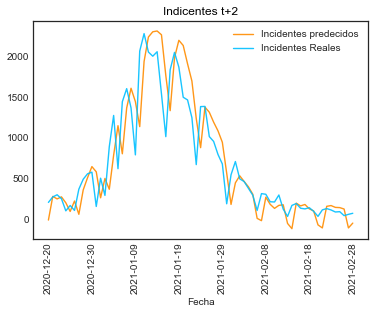

Mean absolute error = 234.23
RMSE = 319.65


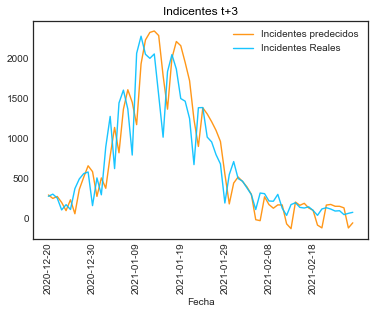

Mean absolute error = 238.52
RMSE = 324.02


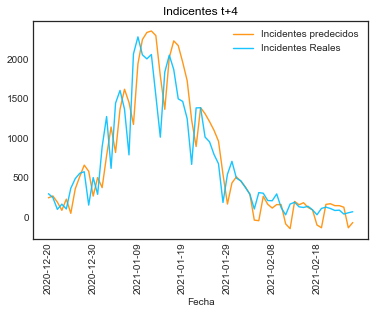

Mean absolute error = 243.99
RMSE = 328.54


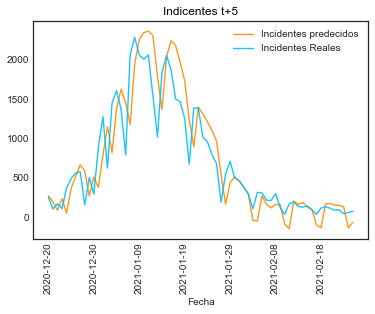

Mean absolute error = 248.09
RMSE = 332.02


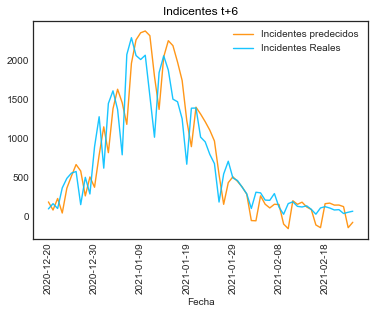

Mean absolute error = 252.39
RMSE = 335.26


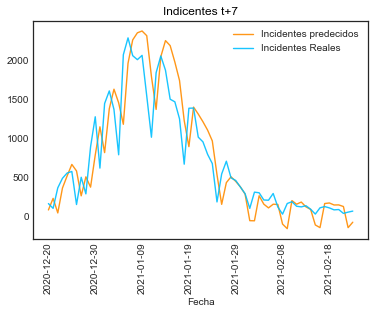

Mean absolute error = 255.41
RMSE = 338.09


In [45]:
predicciones_lasso = calcular_predicciones(optimised_lasso, y_pred)
MAE_lasso, RMSE_lasso = graficas_errores(predicciones_lasso)

## Gradient Boosting Regressor

### Predicción t

La idea de este modelo es construir árboles en serie de forma que un árbol posterior intenta corregir los errores de todos
los anteriores. Parámetros importantes son la profundidad de los árboles, cuándo hacer pre-prunning (útil para evitar el overfitting) y también el ratio de aprendizaje o learning_rate que controla como se esfuerza el árbol actual en corregir los errores de los árboles anteriores. También podemos aumentar el número de árboles con el parámetro n_estimators.
Al contrario que en random forest, usar un número de árboles muy alto en gradient llevará a un modelo mucho más complejo que
puede caer en overfitting. Max_depth suele variar entre 1 y 5

In [46]:
# Instancia del modelo
gbr = GradientBoostingRegressor(random_state = 42)

In [47]:
gbr.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [48]:
grid = {'n_estimators':[50, 100, 250, 500], 
        #'learning_rate': [0.05, 0.1, 0.2, 0.3],
        'max_depth':[3, 4, 5, 8, 10], 
        'min_samples_leaf':[4, 8, 10], 
        'max_features':[2, 3, 5]} 

In [49]:
clf_gbr = search_grid(gbr, grid)

In [50]:
clf_gbr.best_params_

{'max_depth': 5,
 'max_features': 3,
 'min_samples_leaf': 10,
 'n_estimators': 500}

In [51]:
gbr_results = pd.DataFrame(clf_gbr.cv_results_)
gbr_results.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.032114,0.004922,0.003391,0.000661,3,2,4,50,"{'max_depth': 3, 'max_features': 2, 'min_sampl...",-45.678945,...,0.980954,0.979238,0.964640,0.971129,0.993627,0.990291,0.988995,0.982472,0.981844,0.008283
1,0.046275,0.005224,0.004090,0.002337,3,2,4,100,"{'max_depth': 3, 'max_features': 2, 'min_sampl...",-45.747112,...,0.996607,0.995050,0.990022,0.989972,0.998087,0.996844,0.996580,0.993877,0.995301,0.002943
2,0.106614,0.010253,0.003491,0.000669,3,2,4,250,"{'max_depth': 3, 'max_features': 2, 'min_sampl...",-46.065792,...,0.999866,0.999559,0.998827,0.998840,0.999764,0.999600,0.999542,0.999201,0.999506,0.000397


In [52]:
optimised_gbr = clf_gbr.best_estimator_

In [53]:
joblib.dump(optimised_gbr, 'gbr.pkl')

['gbr.pkl']

In [54]:
optimised_gbr = joblib.load('gbr.pkl')

In [55]:
y_pred = optimised_gbr.predict(X_test)

In [56]:
MAE(y_pred, y_test)

Mean absolute error = 303.68


In [57]:
RMSE(y_pred, y_test)

RMSE = 488.39


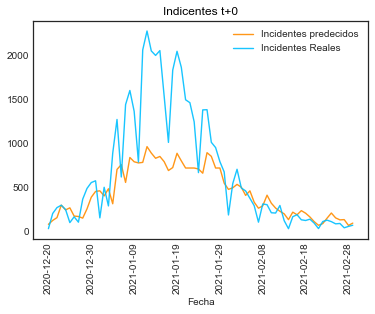

In [58]:
grafica(y_pred, y_test, -1)

In [59]:
np.corrcoef(y_test, y_pred)

array([[1.        , 0.88663485],
       [0.88663485, 1.        ]])

### Predicción 7 días adelante

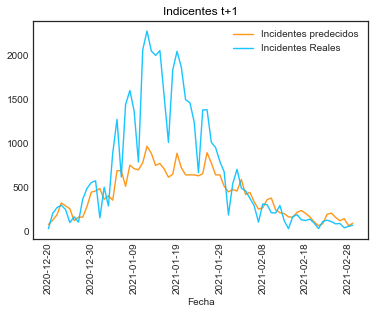

Mean absolute error = 321.63
RMSE = 511.48


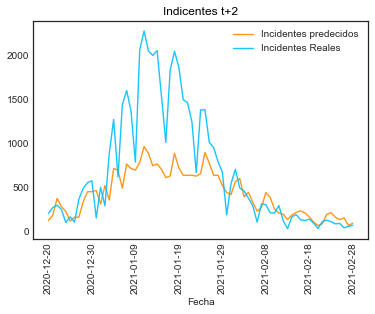

Mean absolute error = 328.67
RMSE = 516.36


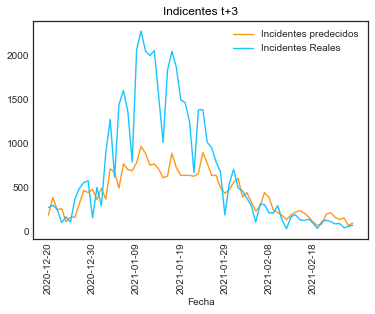

Mean absolute error = 330.56
RMSE = 519.57


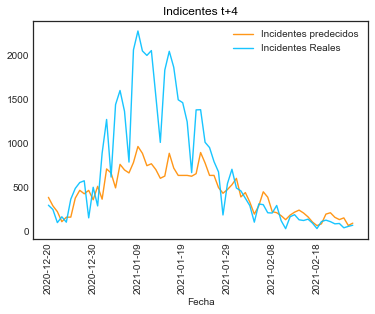

Mean absolute error = 334.11
RMSE = 523.74


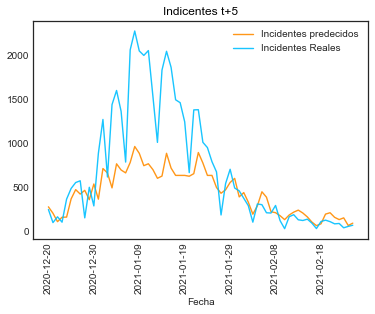

Mean absolute error = 337.2
RMSE = 527.27


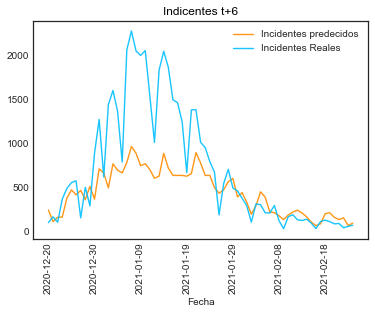

Mean absolute error = 341.99
RMSE = 531.22


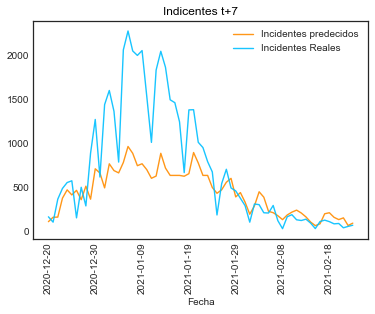

Mean absolute error = 345.26
RMSE = 535.06


In [60]:
predicciones_gbr = calcular_predicciones(optimised_gbr, y_pred)
MAE_gbr, RMSE_gbr = graficas_errores(predicciones_gbr)